In [1]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Embedding, GRU, Merge, RepeatVector, TimeDistributed
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
import numpy as np
import json
from IPython.display import SVG, display

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Using Theano backend.


In [2]:
np.random.seed(13)
filters = base_filter() + "「」・。、（）？！　'"

In [3]:
# ja data
ja_docs = open("data/yellow.ja.txt").readlines()[0:20]
ja_tokenizer = Tokenizer(filters=filters)
ja_tokenizer.fit_on_texts(ja_docs)

ja_docs = ja_tokenizer.texts_to_sequences(ja_docs)

# en data
en_docs = open("data/yellow.en.txt").readlines()
en_docs = list(map(lambda x: "GOS " + x + " EOS" , en_docs))[0:20]
en_tokenizer = Tokenizer(filters=filters)
en_tokenizer.fit_on_texts(en_docs)
en_tokenizer.fit_on_texts(en_docs)

en_docs = en_tokenizer.texts_to_sequences(en_docs)

encoder_maxlen = max([len(x) for x in ja_docs])
decoder_maxlen = max([len(x)-1 for x in en_docs])
encoder_vocab_size = len(ja_tokenizer.word_index)+1
decoder_vocab_size = len(en_tokenizer.word_index)+1

In [4]:
def gen_training_data(X, Y, encoder_maxlen, decoder_maxlen, V, samples_size):
    encoder_inputs = []
    decoder_inputs = []
    next_words = []
    for i in range(len(X)):
        x_doc, y_doc = X[i], Y[i]
        for j in range(1, len(y_doc)):
            decoder_inputs.append(y_doc[0:j])
            next_words.append(y_doc[j])
            encoder_inputs.append(x_doc)
            if len(next_words) == samples_size:                
                labels = np_utils.to_categorical(next_words, V)
                encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
                decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)
                yield ([encoder_inputs, decoder_inputs], labels)
                encoder_inputs = []
                decoder_inputs = []
                next_words = []
    labels = np_utils.to_categorical(next_words, V)
    encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
    decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)

    yield ([encoder_inputs, decoder_inputs], labels)

In [5]:
# encoder one doc to one repeated vector
encoder = Sequential()
encoder.add(Embedding(encoder_vocab_size, 128, input_length=encoder_maxlen))
encoder.add(GRU(128, return_sequences=False))
encoder.add(RepeatVector(decoder_maxlen))

# decoder inputs
decoder_input = Sequential()
decoder_input.add(Embedding(decoder_vocab_size, 128, input_length=decoder_maxlen))
decoder_input.add(GRU(output_dim=128, return_sequences=True))
decoder_input.add(TimeDistributed(Dense(128)))

model = Sequential()
model.add(Merge([encoder, decoder_input], mode='concat', concat_axis=-1))
model.add(GRU(128, return_sequences=False))
model.add(Dense(decoder_vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

# save model without weights
with open('my_model.json', 'w') as f:
    json.dump(model.to_json(), f)


encoder


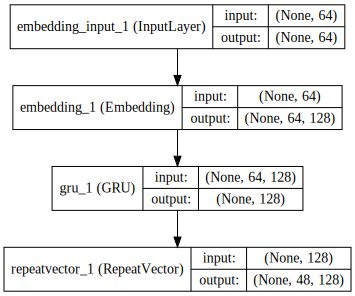

decoder input


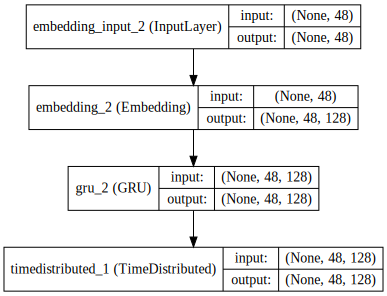

merge and decoder output


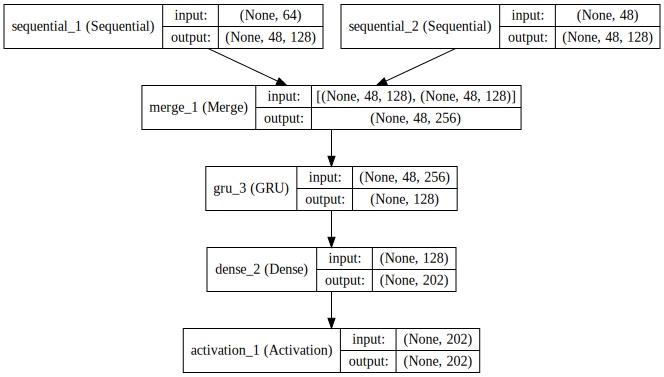

In [6]:
print("encoder")
display(SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg')))
print("decoder input")
display(SVG(model_to_dot(decoder_input, show_shapes=True).create(prog='dot', format='svg')))
print("merge and decoder output")
display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [7]:
for i in range(41):
        loss = 0.
        for x, y in gen_training_data(ja_docs, en_docs, encoder_maxlen, decoder_maxlen, decoder_vocab_size, 256):
            loss += model.train_on_batch(x, y)
        print(i, "loss ", loss)
        if not i % 10:
            model.save_weights('my_model_weights_' + str(i) + '.h5')

0 loss  10.6113305092
[WARNING] my_model_weights_0.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!
1 loss  10.5941448212
2 loss  10.5754294395
3 loss  10.55275774
4 loss  10.522482872
5 loss  10.4775209427
6 loss  10.4023971558
7 loss  10.263671875
8 loss  10.0238938332
9 loss  9.78840446472
10 loss  9.70978784561
11 loss  9.65669202805
12 loss  9.61475896835
13 loss  9.58250999451
14 loss  9.5566778183
15 loss  9.53521299362
16 loss  9.51677894592
17 loss  9.50044488907
18 loss  9.48550701141
19 loss  9.47138595581
20 loss  9.45758152008
21 loss  9.44361877441
22 loss  9.42902088165
23 loss  9.41326904297
24 loss  9.3957695961
25 loss  9.37584161758
26 loss  9.35272979736
27 loss  9.32572984695
28 loss  9.29447746277
29 loss  9.25936555862
30 loss  9.22175979614
31 loss  9.18364238739
32 loss  9.14668989182
33 loss  9.10991430283
34 loss  9.06801080704
35 loss  9.01917695999
36 loss  8.99524641037
37 loss  9.01865911484
38 loss  8.90571880

In [8]:
# load model
model = model_from_json(json.load(open("./my_model.json")))

In [9]:
def sample(p):
    p /= sum(p)
    return np.where(np.random.multinomial(1,p,1)==1)[1][0]

In [10]:
encoder_words = "ホームズ は 答え た"
encoder_in = sequence.pad_sequences(ja_tokenizer.texts_to_sequences([encoder_words]), maxlen=encoder_maxlen)

for i in range(0, 41, 10):
    model.load_weights("./my_model_weights_" + str(i) + ".h5")
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')


    decoder_words = "gos"
    for _ in range(encoder_maxlen):
        decoder_in = sequence.pad_sequences(en_tokenizer.texts_to_sequences([decoder_words]),  maxlen=decoder_maxlen)
        wordid = sample(model.predict([encoder_in, decoder_in])[0])
        
        for k, v in en_tokenizer.word_index.items():
            if v == wordid:
                decoder_words += " " + k
                break
        if k == "eos":
            break

    print(i, decoder_words.replace("gos", "").replace("eos", ""))

0  s sparest interest sticky elms there habits have discovered interest have circumstances truth the breaking strongest were admirable circumstances sketches first forever diet one drug failures actors of professional breaking companion usually elms most reputation just half a then forever greater no use present uninteresting gifts failures it eventually too under remarkable breaking effort truth chanced seldom far greater doyle was without elms than
10  and his the the men and the spring and the their again it save interest adventure were his notes truth that us energy the be when simple conan and of 
20  reputation upon he were of energy doyle he wit with that early of the ritual which rather himself sherlock be me two simple the simple just protest of 
30  were in erred vices he of interest his there in for 
40  the man as because of that reputation of to 
